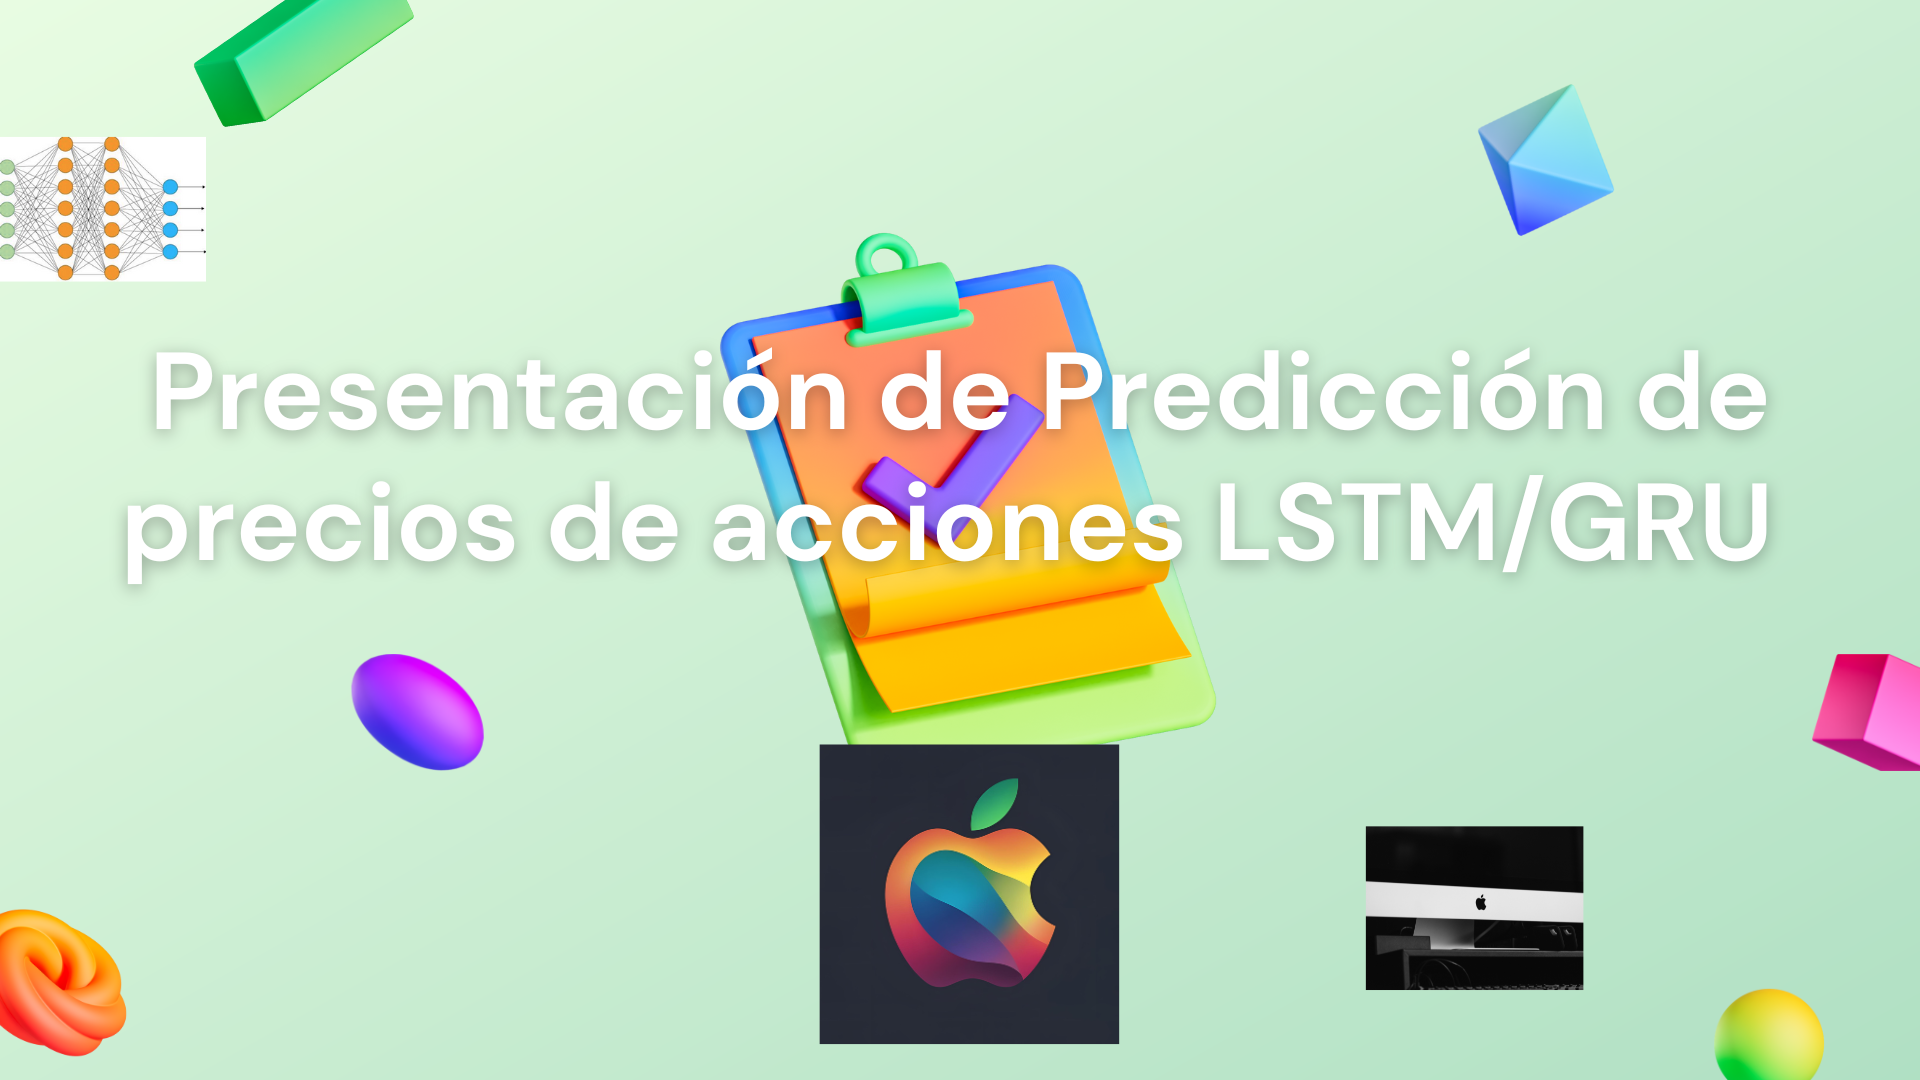

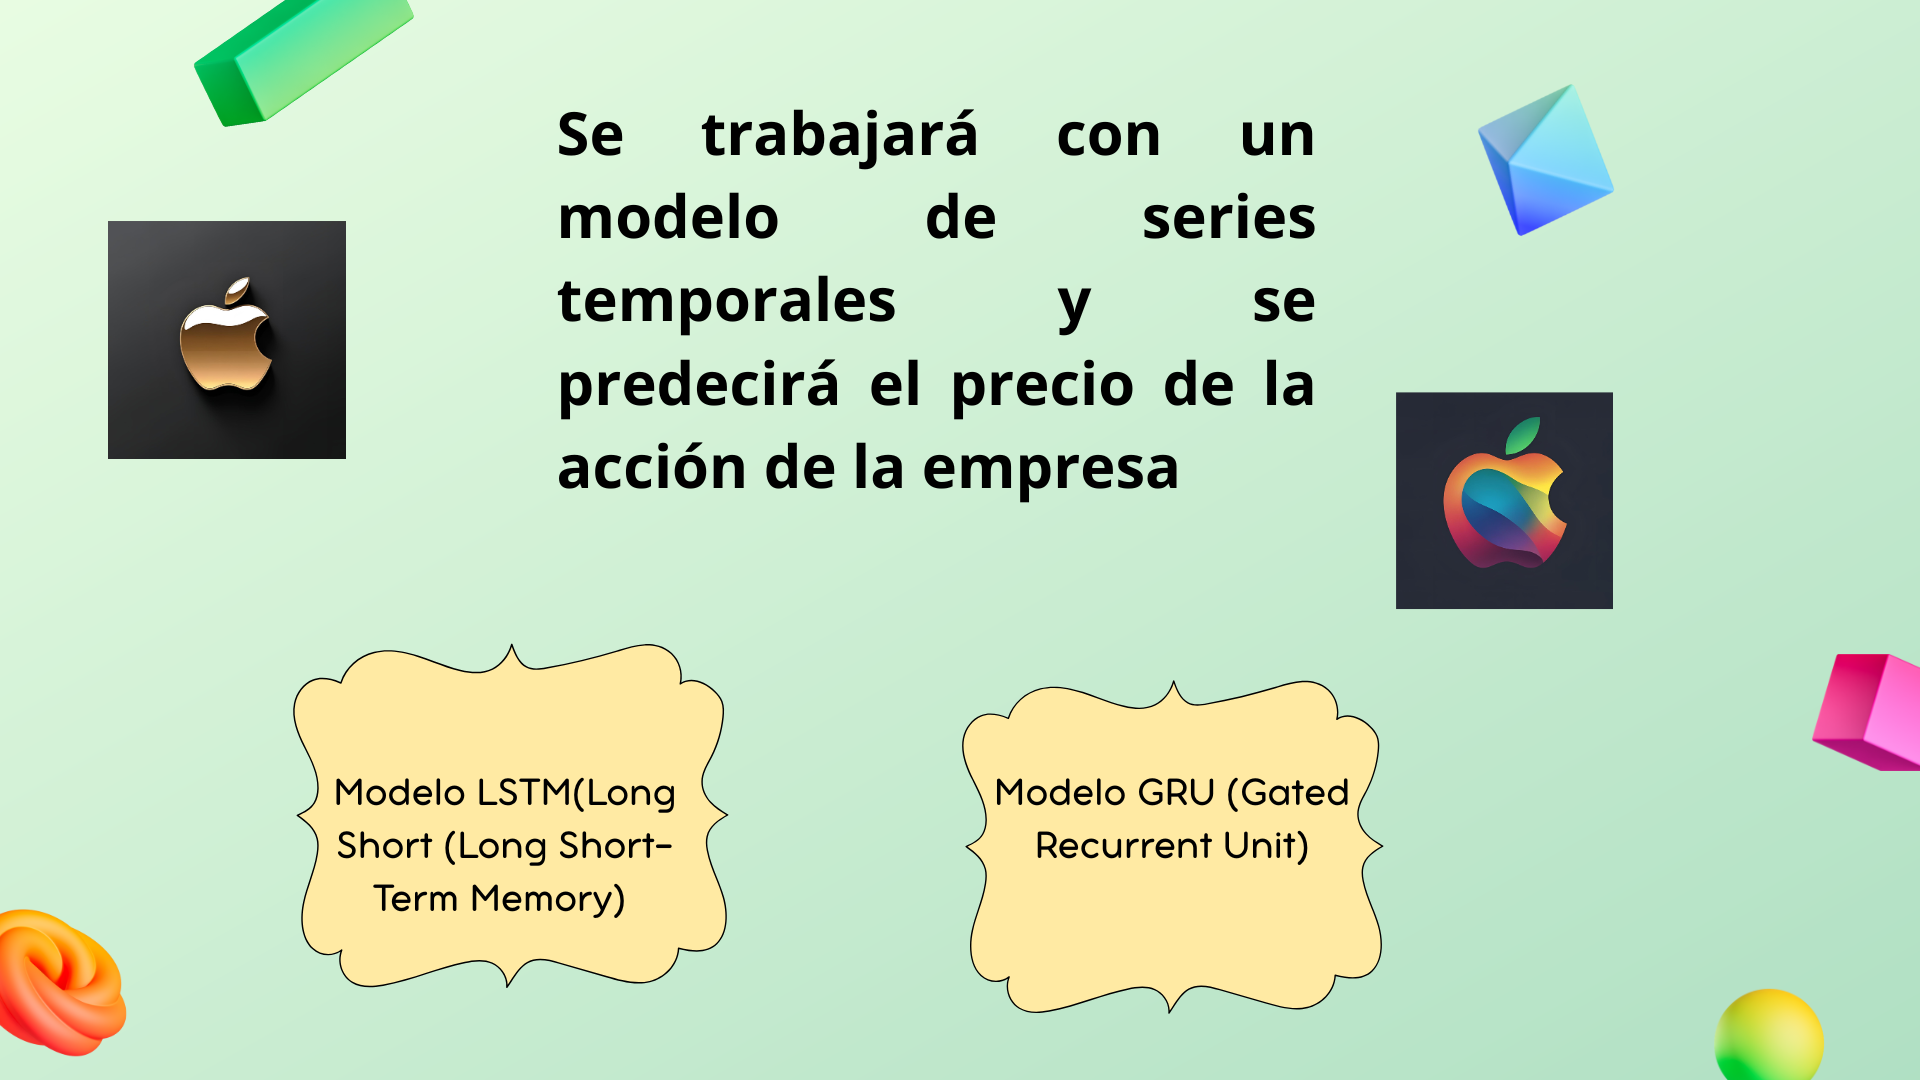

📚 **Importar las librerías necesarias**

In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings   #para gestionar advertencias
warnings.filterwarnings('ignore')  #Desactiva advertencias para una salida más limpia

In [2]:
# Descargar los datos históricos de AAPL (incluyendo precios ajustados)
data = yf.download('AAPL', start="2023-05-17", end="2025-07-17")

# Verificar que los datos fueron descargados correctamente
if not data.empty:
    # Asegurarnos de que la fecha esté como columna (en lugar de índice)
    data = data.reset_index()

    # Comprobar las columnas para ver cuál falta
    print("Columnas actuales:", data.columns)

    # Renombrar las columnas correctamente
    data.columns = ['Date' , 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    # Mostrar las primeras filas para verificar que está todo bien
    print(data.head())
else:
    print("No se pudieron descargar los datos.")


[*********************100%***********************]  1 of 1 completed

Columnas actuales: MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
        Date        High         Low       Close   Adj Close    Volume
0 2023-05-17  170.618896  170.856008  168.376117  169.650654  57951600
1 2023-05-18  172.950623  173.138346  170.510244  170.925205  65496700
2 2023-05-19  173.059280  174.274525  172.841918  174.274525  55809500
3 2023-05-22  172.110794  172.614687  171.369789  171.893431  43570900
4 2023-05-23  169.502457  171.300636  169.225816  171.053635  50747300


In [ ]:
# Descargar los datos históricos de AAPL (incluyendo precios ajustados)
data = yf.download('AAPL', start="2023-05-17", end="2025-07-17")

# Verificar que los datos fueron descargados correctamente
if not data.empty:
    # Asegurarnos de que la fecha esté como columna (en lugar de índice)
    data = data.reset_index()

    # Comprobar las columnas para ver cuál falta
    print("Columnas actuales:", data.columns)

    # Renombrar las columnas correctamente
    data.columns = ['Date' , 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    # Mostrar las primeras filas para verificar que está todo bien
    print(data.head())
else:
    print("No se pudieron descargar los datos.")


In [ ]:
#converir a df
df = pd.DataFrame(data)

In [ ]:
df.head()

,Date,High,Low,Close,Adj Close,Volume
0,2023-05-17,170.618912,170.856024,168.376132,169.650669,57951600
1,2023-05-18,172.950592,173.138316,170.510214,170.925175,65496700
2,2023-05-19,173.059265,174.274509,172.841902,174.274509,55809500
3,2023-05-22,172.110779,172.614672,171.369774,171.893416,43570900
4,2023-05-23,169.502426,171.300606,169.225785,171.053604,50747300


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       542 non-null    datetime64[ns]
 1   High       542 non-null    float64       
 2   Low        542 non-null    float64       
 3   Close      542 non-null    float64       
 4   Adj Close  542 non-null    float64       
 5   Volume     542 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 25.5 KB


In [ ]:
#Visualizar los precios de Apple

fig = px.line(df,
              x='Date',
              y='Adj Close',
              template='none',
              title='Precio con respecto en el tiempo')

#Cambiar el color de la línea y posición del texto
fig.update_traces(line_color='lime', textposition='top center')
#Fondo negro (área del gráfico y papel) y texto en blanco para legibilidad
fig.update_layout(paper_bgcolor='black',
                  plot_bgcolor='black',
                  font_color='white')
fig.show()

In [ ]:
#Gráfico violín ajustado

graf = px.violin(df, y='Adj Close', box=True, points="all", title='Precio de cierre ajustado')

graf.update_layout(paper_bgcolor='black',
                   plot_bgcolor='black',
                   font_color='white')
graf.show()

In [ ]:
# Calcular  la media movil de  10 , 40 y 50 días
df['MA10'] = df['Adj Close'].rolling(window=30).mean()
df['MA40'] = df['Adj Close'].rolling(window=100).mean()
df['MA60'] = df['Adj Close'].rolling(window=180).mean()

# Crear un dataframe
plot_df_ma = df[['Date', 'Adj Close', 'MA10', 'MA40', 'MA60']].copy()

# Melt del DataFrame para Plotly Express
plot_df_ma_melted = plot_df_ma.melt(id_vars='Date', value_vars=['Adj Close', 'MA10', 'MA40','MA60'],
                                   var_name='Tipo', value_name='Precio')

# Crear gráfico interactive  usando Plotly Express
fig_ma = px.line(plot_df_ma_melted, x='Date', y='Precio', color='Tipo',
                 title='Precio de Apple y Medias Móviles',
                 template='plotly_dark')
fig_ma.show()

In [ ]:
data = df[['Adj Close', 'Date']]

❓ Verificar si la serie es estacionaria

In [ ]:
def dickey_fuller(serie):
  """Realiza prueba de Dickey-Fuller"""
  #se importará la función adfuller desde la biblioteca necesaria
  from statsmodels.tsa.stattools import adfuller

  #Realizar la prueba Dickey Fuller
  dftest = adfuller(serie)

  #Extraer las estadísticas de prueba, el valor de p y los valores críticos
  tstat = dftest[0]
  pvalue = dftest[1]
  cvalues = dftest[4]

  #Imprimimos los resultados
  print('\n')
  print('Resultado de la prueba Dickey-fuller')
  print("-------------------")
  print('Estadística de prueba\t', tstat)
  print('p-value\t\t\t',pvalue)
  print("-------------------")
  print('Valores críticos (la estadísca de prueba debe ser menor)')


  #Definir los niveles de confianza
  clevels = [10, 5, 1]
  #Iteramos sobre los niveles de confianza
  for clevel in clevels:
    #Calcular el nivel de confianza
    conf = 100 - clevel
    #Obtenener el valor crítico correspondiente al nivel de confianza
    cval = cvalues[f'{clevel}%']
    #Comparar la estadística de prueba con el valor crítico
    if tstat < cval:
      comp = '>'
      verdict = 'PASA: ES ESTACIONARIA'
    else:
      comp = '<'
      verdict = 'FALLA: NO ES ESTACIONARIA'

    #Imprimir el resultado de la comparación
    print(f'Confianza {conf}%: {tstat} {comp} {cval} {verdict}')

  return


In [ ]:
#🧑 Verificar la función
dickey_fuller(df['Adj Close'])




Resultado de la prueba Dickey-fuller
-------------------
Estadística de prueba	 -1.905542804649893
p-value			 0.32945811015109583
-------------------
Valores críticos (la estadísca de prueba debe ser menor)
Confianza 90%: -1.905542804649893 < -2.5696391843672695 FALLA: NO ES ESTACIONARIA
Confianza 95%: -1.905542804649893 < -2.866927190004947 FALLA: NO ES ESTACIONARIA
Confianza 99%: -1.905542804649893 < -3.442563336759378 FALLA: NO ES ESTACIONARIA


⚒ Trabajo previo de preparación de datos

In [ ]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1, 1))

# Crear secuencias de datos para LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Secuencia de precios previos
        y.append(data[i])   # Precio del siguiente día
    return np.array(X), np.array(y)

# Usar los últimos 40 días para predecir el siguiente día
seq_length = 40
X, y = create_sequences(scaled_data, seq_length)


In [ ]:
# Dividir en entrenamiento y prueba (80/20)
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

# Normalizar X_train y X_test
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])) # Reshape for scaling
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2]))  # Reshape para escalar

# Reshape para LSTM
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)  # Correct reshape
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

# Normalizar y_train y y_test
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

#Modelo LSTM
![imagen](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%2Fid%2FOIP.QGS3X-bbltcoA7B1_7Tl0wHaEK%3Fpid%3DApi&f=1&ipt=e70005ecd8fd72b1f7325280e13725cd47818842f6146360ba7858f61341a0a9&ipo=images)

👀 LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente (RNN) creada por Sepp Hochreiter y Jürgen Schmidhuber en 1997, diseñada para resolver problemas de dependencias a largo plazo en secuencias de datos. Su popularidad ha crecido especialmente en tareas como reconocimiento de voz, traducción automática, generación de texto y finanzas.

💹Características principales:

    Celdas de memoria: Son el núcleo de la LSTM, permitiendo que la red retenga información durante más tiempo.

    Puertas: Cada celda tiene tres puertas que regulan el flujo de información:

        Puerta de entrada: Decide qué información almacenar.

        Puerta de olvido: Determina qué información se debe descartar.

        Puerta de salida: Controla qué información se pasa a la siguiente capa.
😜 Ventajas:

    Capturan dependencias a largo plazo, lo que las hace ideales para procesar secuencias de datos.

    Son eficaces en tareas complejas donde otras redes RNN tradicionales fallan.

😞Limitaciones:

    Aunque potentes, las LSTM pueden ser costosas en términos de computación y memoria.

    No son inmunes al problema de explosión o desvanecimiento del gradiente, aunque esto se mitiga más que en las RNN tradicionales.

In [ ]:
#Crear modelo LSTM Simplificado

model = Sequential()

#Capas
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dropout(0.2))  #para evitar reajuste
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=16, activation='tanh', return_sequences=False))
#model.add(Dropout(0.05))
#Capa de salida
model.add(Dense(units=1))

#Compilar el modelo
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

#Resumen del modelo
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 40, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 40, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,465 (126.82 KB)

 Trainable params: 32,465 (126.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Definir EarlyStopping y ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Entrenamiento
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
     verbose=1
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0761 - val_loss: 0.0116
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0084 - val_loss: 0.0136
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0062 - val_loss: 0.0131
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0042 - val_loss: 0.0073
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0047 - val_loss: 0.0145
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0042 - val_loss: 0.0123
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/ste

In [ ]:
y_pred_scaled = model.predict(X_test_scaled)

#Inversa de la normalización
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled).reshape(-1, 1)

#Comparación
pred_df = pd.DataFrame({'Real': y_test_actual.flatten(), 'Prediccion': y_pred.flatten()})
display(pred_df.head())


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step


,Real,Prediccion
0,0.861074,0.848981
1,0.871896,0.859101
2,0.860967,0.873656
3,0.893860,0.862995
4,0.854538,0.893473


In [ ]:
# Función para evaluar las métricas
def evaluacion_metrics(y_true, y_pred):
    # Calcular MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Calcular MAPE

    print('Resultados de la Evaluación de Métricas:')
    print(f'MSE: {mean_squared_error(y_true, y_pred):.2f}')  # MSE
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')  # MAE
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')  # RMSE
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred):.2f}')  # MAPE
    print(f'R2: {r2_score(y_true, y_pred):.2f}')  # R2

# Evaluar el modelo
evaluacion_metrics(y_test_actual, y_pred)

NameError: name 'y_test_actual' is not defined

📈 MSE (Error Cuadrático Medio): 0.00
El valor de 0.00 en MSE indica que el modelo sigue realizando predicciones extremadamente cercanas a los valores reales. Esto sugiere que el modelo está aprendiendo correctamente y ajustándose bien a los datos.<br>

📈 MAE (Error Absoluto Medio): 0.04
Un MAE de 0.04 es un valor bajo, lo que significa que el error absoluto promedio es pequeño. Esto indica que, en promedio, el modelo se equivoca solo en 4 centavos en la predicción del precio.

📈 RMSE (Raíz del Error Cuadrático Medio): 0.06
El RMSE de 0.06 también es un buen indicador de que el modelo está realizando predicciones precisas, ya que el error cuadrático promedio es bajo.

📈 MAPE (Error Porcentual Absoluto Medio): 12.36
El MAPE de 12.36% indica que el modelo tiene un margen de error de alrededor de ese valor. Aunque no es un error excesivo, puede ser mejorado.

📈Relación entre RMSE y MAE:
El RMSE es mayor que el MAE, lo que sugiere que existen factores que podrían estar influyendo en los errores del modelo. Esto puede ser útil para identificar áreas de mejora en el ajuste del modelo.

📈R² (Coeficiente de Determinación): 0.84
El valor de R²  indica que el modelo explica el 84% de la varianza en los datos, lo cual es un resultado bastante bueno.

In [ ]:
import plotly.graph_objects as go

# Crear un gráfico interactivo comparando los valores reales y predichos
fig = go.Figure()

# Añadir los valores reales
fig.add_trace(go.Scatter(
    x=df['Date'].iloc[len(X_train) + seq_length:], # Get the corresponding dates for the test set
    y=y_test_actual.flatten(),  # Asegúrate de que los valores sean 1D
    mode='lines',
    name='Valor Real',
    line=dict(color='blue')
))

# Añadir las predicciones desnormalizadas
fig.add_trace(go.Scatter(
    x=df['Date'].iloc[len(X_train) + seq_length:], # Get the corresponding dates for the test set
    y=y_pred.flatten(),  # Asegúrate de que los valores sean 1D
    mode='lines',
    name='Predicción',
    line=dict(color='red')
))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Valores Reales',
    xaxis_title='Fecha',
    yaxis_title='Precio de Cierre Ajustado',
    template='plotly_dark',  # Estilo visual
    hovermode='closest'
)

# Mostrar la gráfica interactiva
fig.show()

In [ ]:
# Evaluación en los datos de entrenamiento
train_eval = model.evaluate(X_train_scaled, y_train_scaled)
print("Evaluación en el conjunto de entrenamiento:", train_eval)

# Evaluación en los datos de prueba
test_eval = model.evaluate(X_test_scaled, y_test_scaled)
print("Evaluación en el conjunto de prueba:", test_eval)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.9303e-04
Evaluación en el conjunto de entrenamiento: 0.0011892261682078242
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0044
Evaluación en el conjunto de prueba: 0.003956671338528395


In [ ]:
initial_sequence_start_index = len(scaled_data) - seq_length
current_sequence = scaled_data[initial_sequence_start_index:].reshape(1, seq_length, 1)

# Realiza la predicción para el siguiente valor
predicted_value_scaled = model.predict(current_sequence)
predicted_value = scaler.inverse_transform(predicted_value_scaled)

print(f"Predicción para el siguiente día: {predicted_value[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicción para el siguiente día: 211.32


🙂 El precio de la acción al día siguiente cerró 💲211.18

📈 Predicciones a 2 días

In [ ]:
predictions = []


initial_sequence_start_index = len(scaled_data) - seq_length
current_sequence = scaled_data[initial_sequence_start_index:].reshape(1, seq_length, 1)

print(f"Shape of initial current_sequence: {current_sequence.shape}")

for _ in range(2):
    # Predicción para the next day
    predicted_value_scaled = model.predict(current_sequence)
    predicted_value = scaler.inverse_transform(predicted_value_scaled)

    predictions.append(predicted_value[0][0])

    # Update the sequence for the next prediction
    # Take the last seq_length-1 elements and append the new prediction
    current_sequence = np.append(current_sequence[:, 1:, :], predicted_value_scaled.reshape(1, 1, 1), axis=1)

print("Predicciones para los próximos 2 días:")
for i, pred in enumerate(predictions):
    print(f"Día {i+1}: {pred:.2f}")

Shape of initial current_sequence: (1, 40, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicciones para los próximos 2 días:
Día 1: 211.32
Día 2: 212.26


📅 . Dia 1: real 211.18 vs predicción 211.32<br>
📅 . Dia 2: real 212.48 vs predicción 212.26<br>

#💰 Análisis Económico Simulado

In [ ]:
# Variables iniciales
initial_cash = 10000  # Capital inicial
cash = initial_cash
stock = 0  # Número de acciones compradas
transaction_cost = 0.001  # Costo de la transacción (0.1%)
investment_percentage = 0.2  # 20% del capital para cada operación
window = 20  # Número de días para la media móvil
std_multiplier = 1  # Umbral de desviación estándar para comprar/vender

# Obtener el índice de inicio para el conjunto de pruebas en los datos originales
test_set_start_index = len(X_train) + seq_length

# Calcular la media móvil y la desviación estándar
data['MA20'] = data['Adj Close'].rolling(window=window).mean()
data['Std20'] = data['Adj Close'].rolling(window=window).std()

# Simulación de estrategia de reversión a la media
for i in range(window, len(y_pred)):
    data_index = test_set_start_index + i
    if data_index >= len(data):  # Asegurarse de no salir del índice
        break

    # Condición de compra: Si el precio está por debajo de la media móvil - 1 desviación estándar
    if (data['Adj Close'].iloc[data_index] < data['MA20'].iloc[data_index] - std_multiplier * data['Std20'].iloc[data_index] and
        cash >= data['Adj Close'].iloc[data_index]):

        # Determinar cuánto invertir
        amount_to_invest = cash * investment_percentage
        num_shares = amount_to_invest // data['Adj Close'].iloc[data_index]
        cash -= num_shares * data['Adj Close'].iloc[data_index]
        stock += num_shares

        # Costo de la transacción
        cash -= cash * transaction_cost

    # Condición de venta: Si el precio está por encima de la media móvil + 1 desviación estándar
    if (data['Adj Close'].iloc[data_index] > data['MA20'].iloc[data_index] + std_multiplier * data['Std20'].iloc[data_index] and
        stock > 0):

        # Realizar la venta
        cash += stock * data['Adj Close'].iloc[data_index]
        stock = 0

        # Costo de la transacción
        cash -= stock * data['Adj Close'].iloc[data_index] * transaction_cost

# Valor final de la estrategia (efectivo + valor de las acciones)
final_value = cash + stock * data['Adj Close'].iloc[test_set_start_index + len(y_pred) - 1]
print(f"Valor Final de la Estrategia: 💲{final_value:.2f}")
print(f"Ganancia Neta 💲{final_value - initial_cash:.2f}")

# Rentabilidad acumulada
cumulative_profit = ((final_value - initial_cash) / initial_cash) * 100
print(f"Rentabilidad Acumulada: {cumulative_profit:.2f}%")


Valor Final de la Estrategia: 💲10786.62
Ganancia Neta 💲786.62
Rentabilidad Acumulada: 7.87%


#🤔 Trabajo posterior comparar rentabilidad con otras inversiones para tomar la decisión correcta

#Ahora se usará modelo GRU

![imagen](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%2Fid%2FOIP.RXfbn6qYa42DDPklnBbcLwHaDj%3Fpid%3DApi&f=1&ipt=3c8608375d2dbc64cc11dad61419637d03fca402674f65a5d86f873f1a3824cc&ipo=images)


# 💪 Prepación de los datos

In [ ]:
data = df[['Adj Close', 'Date']]

# Normalizar los datos primero
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1, 1))

# Crear secuencias de datos para LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Secuencia de precios previos
        y.append(data[i])   # Precio del siguiente día
    return np.array(X), np.array(y)

# Usar los últimos 40 días para predecir el siguiente día
seq_length = 40
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
# Dividir en entrenamiento y prueba (80/20)
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

# Normalizar X_train y X_test
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])) # Reshape for scaling
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2]))  # Reshape for scaling

# Hacer reshape
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

# Normalizar y_train y y_test
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

#Modelo GRU
![imagen](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%2Fid%2FOIP.FAq-8Lnhrf5ghOMFdeA50AHaGN%3Fpid%3DApi&f=1&ipt=22ef947181abed5e607acf7c9031d210eb74c30eaffbbc19b6fb118b10b6f8ef&ipo=images)

👀 Las Unidades Recurrentes con Compuertas (GRU) fueron introducidas en 2014 por Kyunghyun Cho y colaboradores como una alternativa simplificada y eficiente a las LSTM. Ambas están diseñadas para manejar dependencias a largo plazo, pero las GRU buscan mejorar la eficiencia computacional y simplificar el modelo.
Características principales:

    Puertas de control: Al igual que las LSTM, las GRU usan "compuertas" para decidir qué información conservar, olvidar o actualizar. Sin embargo, las GRU tienen solo dos puertas:    

        ✅ Puerta de actualización: Combina las funciones de las puertas de entrada y olvido en las LSTM, controlando la cantidad de información a conservar de un paso a otro.

        ✅ Puerta de reinicio: Regula cuánto de la información previa se debe olvidar para dar paso a nuevos datos.

    Estado oculto y celda combinados: En las GRU, el estado de la celda y el estado oculto se combinan, lo que reduce la complejidad y mejora la eficiencia computacional durante el entrenamiento.
    

🤭 Ventajas:

    ✅ Eficiencia computacional: Debido a su arquitectura más simple, las GRU son más rápidas y menos costosas en términos de recursos de entrenamiento en comparación con las LSTM.

    ✅ Mejor desempeño en tareas simples o medianamente complejas, especialmente en tareas de procesamiento de lenguaje natural (PLN) y predicción de series temporales.

🤕 Limitaciones:

    Menos control preciso: Aunque las GRU son más rápidas, la simplicidad de su arquitectura puede no ser suficiente para tareas muy complejas, donde las LSTM pueden ofrecer un control más fino.

    No siempre mejor rendimiento: En algunas aplicaciones, las LSTM pueden seguir superando a las GRU, por lo que la elección entre ambas depende de la tarea y el rendimiento empírico.

⚡ Las GRU son muy populares por su balance entre eficiencia y precisión, especialmente cuando los recursos computacionales son limitados. La elección entre LSTM y GRU generalmente se decide en función de la tarea específica, y es común realizar una evaluación empírica para determinar cuál da mejores resultados.

In [ ]:
from tensorflow.keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(16, return_sequences=False))
model_gru.add(Dropout(0.1))
#ültima capa
model_gru.add(Dense(1))

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='mean_squared_error') #



# Entrenar el modelo
history = model_gru.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 0.0842 - val_loss: 0.0092
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0166 - val_loss: 0.0324
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/s

In [ ]:
# Hacer predicciones
y_pred_scaled = model_gru.predict(X_test)

# Desnormalizar los valores predichos y reales
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Evaluación de métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Resultados:")
print(f"MSE: {mean_squared_error(y_test_actual, y_pred_actual):.2f}")
print(f"MAE: {mean_absolute_error(y_test_actual, y_pred_actual):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, y_pred_actual):.2f}")
print(f"R²: {r2_score(y_test_actual, y_pred_actual):.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
Resultados:
MSE: 30.67
MAE: 3.55
RMSE: 5.54
MAPE: 1.74
R²: 0.86


📉 MSE (Error Cuadrático Medio): 30.67
El MSE sugiere que el modelo penaliza considerablemente los errores y tiene ciertos problemas en su proceso de aprendizaje. Este valor relativamente alto indica que hay margen de mejora en la precisión del modelo.

📉 MAE (Error Absoluto Medio): 3.55
Con un MAE de 3.55, el modelo en promedio se equivocaría en 3.55 dólares al hacer sus predicciones, lo que refleja un error considerable en términos absolutos.

📉 RMSE (Raíz del Error Cuadrático Medio): 5.54
El  RMSE sigue siendo un indicador de que el modelo tiene dificultades para realizar predicciones precisas. Este valor, como el MSE, señala que el modelo podría estar siendo influenciado por algunos errores grandes.

📉 MAPE (Error Porcentual Absoluto Medio): 1.74%
El MAPE de 1.74% es bastante bajo, lo que indica que, en términos porcentuales, el modelo tiene un margen de error pequeño, lo cual es positivo.<br>

📉 Relación entre RMSE y MAPE:
El RMSE es mayor que el MAPE, lo que sugiere que los errores del modelo no son uniformes y que algunos de los errores grandes están afectando la métrica de RMSE más que la de MAPE.

📉 R² (Coeficiente de Determinación): 86%
El R² significa que el modelo es capaz de explicar el 86% de la varianza en los datos, lo cual es un buen resultado. Este valor es bastante alto, lo que sugiere que el modelo tiene una buena capacidad predictiva en general.



In [ ]:
import plotly.graph_objects as go


fig = go.Figure()

# Agregar la línea de los valores reales
fig.add_trace(go.Scatter(
    x=df['Date'],
    y=y_test_actual.flatten(),
    mode='lines',  # Tipo de gráfico: líneas
    name='Valores Reales',
    line=dict(color='blue')
))

# Agregar la línea de las predicciones
fig.add_trace(go.Scatter(
    x=df['Date'],
    y=y_pred_actual.flatten(),
    mode='lines',
    name='Predicciones GRU',
    line=dict(color='red', dash='dash')  # Línea punteada para las predicciones
))

# Título y etiquetas
fig.update_layout(
    title='Predicción GRU vs Valores Reales',
    xaxis_title='Fecha',
    yaxis_title='Precio de la Acción',
    template='plotly_dark',
    xaxis=dict(
        tickformat="%Y-%m-%d",
        tickangle=45,
    )
)

# Mostrar el gráfico interactivo
fig.show()


# 🤔 Predecir con el modelo GRU

In [ ]:
initial_sequence_start_index = len(scaled_data) - seq_length
current_sequence = scaled_data[initial_sequence_start_index:].reshape(1, seq_length, 1)

# Realiza la predicción para el siguiente valor
predicted_value_scaled = model_gru.predict(current_sequence)
predicted_value = scaler.inverse_transform(predicted_value_scaled)

print(f"Predicción para el siguiente día: {predicted_value[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicción para el siguiente día: 211.31


El precio de la acción al día siguiente cerró 💲211.18

📈 Predicciones a 2 días

In [ ]:
predictions = []


initial_sequence_start_index = len(scaled_data) - seq_length
current_sequence = scaled_data[initial_sequence_start_index:].reshape(1, seq_length, 1)

print(f"Shape of initial current_sequence: {current_sequence.shape}")

for _ in range(2):
    # Predicción para the next day
    predicted_value_scaled = model_gru.predict(current_sequence)
    predicted_value = scaler.inverse_transform(predicted_value_scaled)

    predictions.append(predicted_value[0][0])

    # Update the sequence for the next prediction
    # Take the last seq_length-1 elements and append the new prediction
    current_sequence = np.append(current_sequence[:, 1:, :], predicted_value_scaled.reshape(1, 1, 1), axis=1)

print("Predicciones para los próximos 2 días:")
for i, pred in enumerate(predictions):
    print(f"Día {i+1}: {pred:.2f}")

Shape of initial current_sequence: (1, 40, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicciones para los próximos 2 días:
Día 1: 211.31
Día 2: 212.19



# 📅 .  Dia 1: real 211.18 vs predicción 211.31<br>
# 📅 .  Dia 2: real 212.48 vs predicción 212.19<br>


#Comparación  de ambos modelos
![imagen](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%2Fid%2FOIP.z_c8tdN5xW_UyTwtcvxJvgHaC2%3Fpid%3DApi&f=1&ipt=a13cfd2945f1acf04354542b0f813bb2d42c85b69453c4348d5221a53d214c38&ipo=images)

💰 Análisis Económico Simulado

In [ ]:
# Definir el costo de transacción
transaction_cost = 0.001  # 0.1%

# Variables para almacenar los resultados
initial_cash = 10000  # Imaginemos que comenzamos con $10,000
cash = initial_cash
stock = 0  # Número de acciones que tenemos (empezamos sin acciones)

# Lista para guardar los rendimientos de la estrategia
strategy_returns = []  # Para el cálculo del ratio de Sharpe
previous_cash = initial_cash  # Almacenamos el efectivo inicial

# Umbral de cambio de predicción para activar las compras (ahora más alto)
threshold = 3  # 3% de diferencia entre días para considerar la compra

# Porcentaje de ganancia mínima para vender (para evitar ventas prematuras)
profit_target = 0.03  # Vender si la ganancia supera el 3%

# Simulación de estrategia compra/venta
for i in range(1, len(y_pred)):
    # Condición para comprar: la predicción debe ser un 3% mayor que la anterior
    if (y_pred[i] - y_pred[i-1]) / y_pred[i-1] > threshold / 100 and cash >= data['Adj Close'][i]:  # Predicción alcista y suficiente capital
        # Realizar la compra
        num_shares = cash // data['Adj Close'][i]
        cash -= num_shares * data['Adj Close'][i]
        stock += num_shares

        # Costo de la transacción (comisión de compra)
        cash -= cash * transaction_cost

        # Guardar el rendimiento de la estrategia
        strategy_returns.append((cash + stock * data['Adj Close'][i] - previous_cash) / previous_cash)

    # Condición para vender: si hay un beneficio superior al 3%
    elif stock > 0 and (data['Adj Close'][i] - data['Adj Close'][i-1]) / data['Adj Close'][i-1] > profit_target:  # Si la ganancia supera el 3%
        # Realizar la venta
        cash += stock * data['Adj Close'][i]
        stock = 0

        # Costo de la transacción (comisión de venta)
        cash -= cash * transaction_cost

        # Guardar el rendimiento de la estrategia
        strategy_returns.append((cash - previous_cash) / previous_cash)

    previous_cash = cash  # Actualizamos el efectivo para la próxima iteración

# El valor final de la estrategia es el efectivo más el valor de las acciones
final_value = cash + stock * data['Adj Close'].iloc[-1]
print(f"Valor Final de la Estrategia: 💲{final_value:.2f}")
print(f"Ganancia Neta 💲{final_value - initial_cash:.2f}")

# Rentabilidad acumulada
cumulative_profit = ((final_value - initial_cash) / initial_cash) * 100
print(f"Rentabilidad Acumulada: {cumulative_profit:.2f}%")

# Volatilidad (Desviación estándar de los retornos)
returns = np.diff(data['Adj Close']) / data['Adj Close'][:-1]
volatility = np.std(returns) * np.sqrt(252)  # Anualizar la volatilidad
print(f"Volatilidad: {volatility:.2f}")

Valor Final de la Estrategia: 💲12255.34
Ganancia Neta 💲2255.34
Rentabilidad Acumulada: 22.55%
Volatilidad: 0.29


🤔 Trabajo posterior comparar rentabilidad con otras inversiones para tomar la decisión correcta

#Comparación  de ambos modelos
![imagen](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%2Fid%2FOIP.z_c8tdN5xW_UyTwtcvxJvgHaC2%3Fpid%3DApi&f=1&ipt=a13cfd2945f1acf04354542b0f813bb2d42c85b69453c4348d5221a53d214c38&ipo=images)

📈 LSTM:

        Ofrece una precisión mucho mayor en términos absolutos (MAE y RMSE bajos).

        Aunque su MAPE es más alto que el de GRU, su capacidad para hacer predicciones cercanas a los valores reales es sobresaliente.

        R² de 84%, que es un buen rendimiento.

📈 GRU:

        MSE y MAE más altos, lo que indica que tiene dificultades para ajustar correctamente los valores de predicción.

        El MAPE bajo sugiere que el modelo tiene una buena tasa de error porcentual, pero se ve afectado por errores absolutos más grandes.

        Su R² es un poco mejor (86%), lo que sugiere que puede explicar un poco más de la varianza de los datos que el modelo LSTM.

# ❓ ¿Qué modelo elegir?
LSTM parece ser la opción más precisa en términos absolutos y de error cuadrático, pero GRU tiene un rendimiento comparable en cuanto a la capacidad para explicar la varianza y un MAPE más bajo.

    Si la precisión y la reducción de errores absolutos son más importantes, el LSTM sería la mejor opción. Si el objetivo es tener un modelo con un error porcentual bajo y un R² más alto, el GRU podría ser una opción a considerar.



#📉 En cuanto a precisón de precio
Modelo LSTM:

    Día 1:

        Valor Real: 211.18

        Predicción LSTM: 211.32

        Diferencia: 0.14

    Día 2:

        Valor Real: 212.48

        Predicción LSTM: 212.26

        Diferencia: 0.22

Resumen LSTM:
Las predicciones de LSTM son muy cercanas a los valores reales, con una diferencia pequeña de 0.14 en el Día 1 y 0.22 en el Día 2, lo que refleja un alto grado de precisión.
Modelo GRU:

    Día 1:

        Valor Real: 211.18

        Predicción GRU: 211.31

        Diferencia: 0.13

    Día 2:

        Valor Real: 212.48

        Predicción GRU: 212.19

        Diferencia: 0.29

Resumen GRU:
Las predicciones de GRU también son bastante cercanas a los valores reales, con diferencias de 0.13 en el Día 1 y 0.29 en el Día 2, mostrando un buen desempeño.
Comparación de Resultados:

    Día 1:

        LSTM: 0.14

        GRU: 0.13
        En el Día 1, GRU tiene una predicción ligeramente más precisa que LSTM, con una diferencia de solo 0.13 frente a 0.14.

    Día 2:

        LSTM: 0.22

        GRU: 0.29
        En el Día 2,LSTM e tiene una diferencia más pequeña (0.22) en comparación con GRU (0.29).

Conclusión:

Ambos modelos tienen un rendimiento excelente, con diferencias pequeñas entre las predicciones y los valores reales. GRU parece ligeramente más preciso en ambos días, pero las diferencias son mínimas, lo que indica que ambos modelos son confiables y adecuados para la tarea de predicción.


#📊 Conclusión:
Ambos modelos tienen un rendimiento excelente, con diferencias pequeñas entre las predicciones y los valores reales. GRU parece ligeramente más preciso en ambos días, pero las diferencias son mínimas, lo que indica que ambos modelos son confiables y adecuados para la tarea de predicción.

Hay algunos elementos a tener en cuenta:


📈 1.   Si se busca mayor precisión:
Aunque la diferencia es pequeña, GRU ha tenido un rendimiento ligeramente mejor en estos ejemplos con una diferencia de predicción más pequeña en ambos días. Si la precisión es la  prioridad y e interesa minimizar los errores absolutos, GRU podría ser la mejor opción, especialmente si los recursos computacionales son una limitación.<br>
📈  2.   Si la capacidad de aprendizaje y robustez es más importante:
LSTM generalmente tiene una capacidad de aprendizaje más robusta, especialmente cuando se enfrentan a secuencias largas o problemas complejos, ya que es más efectivo en capturar dependencias a largo plazo debido a su arquitectura. Si se trabaja con datos con patrones complejos o secuencias largas, LSTM puede ser la opción correcta.<br>
📈  3.   Si se prefiere un modelo más efciente y rápido:
GRU tiene menos parámetros que LSTM y, por lo tanto, tiende a ser más rápido en términos de entrenamiento y ejecución, sin sacrificar mucho en cuanto a precisión. Si existen limitaciones de tiempo o recursos computacionales (por ejemplo, entrenamiento en un ambiente con restricciones), GRU podría ser más adecuado.<br>
📈  4.   Si se considera la complejidad de los datos:
Si los datos son más sencillos, con poca variabilidad o sin patrones a largo plazo, GRU puede ser suficiente y ofrecerte un rendimiento muy similar al de LSTM, pero con una mayor eficiencia.<br>
📈 5. Evaluación continua:
Para estar más seguro sería seguir evaluando ambos modelos con más datos para ver si los resultados son consistentes A veces, una evaluación más amplia de diferentes períodos o series temporales puede revelar cuál es el modelo más adecuado a largo plazo.







